## Setting Environment

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

os.environ["HADOOP_HOME"] = "C:\hadoop"
os.environ["HADOOP_OPTS"] = "-Djava.library.path=C:\spark-3.5.4-bin-hadoop3\bin"

## Importing Libraries

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, to_date, lpad, concat_ws, mean, expr, udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql import functions as F
import pandas as pd
import numpy as np

## Initializing Spark Session

In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("CrimeDataAnalysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.python.worker.reuse", "true") \
    .config("spark.network.timeout", "10000000") \
    .config("spark.hadoop.io.nativeio.NativeIO.Windows", False)\
    .getOrCreate()


## Load Dataset and display Schema

In [4]:
# Load the dataset
data_path = "Crime_Data_from_2020_to_Present.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Display schema
df.printSchema()

root
 |-- DR_NO: integer (nullable = true)
 |-- Date Rptd: string (nullable = true)
 |-- DATE OCC: string (nullable = true)
 |-- TIME OCC: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- Rpt Dist No: integer (nullable = true)
 |-- Part 1-2: integer (nullable = true)
 |-- Crm Cd: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- Mocodes: string (nullable = true)
 |-- Vict Age: integer (nullable = true)
 |-- Vict Sex: string (nullable = true)
 |-- Vict Descent: string (nullable = true)
 |-- Premis Cd: integer (nullable = true)
 |-- Premis Desc: string (nullable = true)
 |-- Weapon Used Cd: integer (nullable = true)
 |-- Weapon Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status Desc: string (nullable = true)
 |-- Crm Cd 1: integer (nullable = true)
 |-- Crm Cd 2: integer (nullable = true)
 |-- Crm Cd 3: integer (nullable = true)
 |-- Crm Cd 4: integer (nullable = true)
 |-- L

## Dropping unnecessary columns, handling missing values, displaying count of null per columns

In [5]:
# Drop unnecessary columns
drop_columns = ['DR_NO', 'AREA', 'Mocodes', 'Premis Cd', 'Weapon Used Cd', 
                'Crm Cd 1', 'Status', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street']
df = df.drop(*drop_columns)

# Handling missing values by dropping 'Weapon Desc' column
df = df.drop("Weapon Desc")

# Display count of null values per column
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns]).show()


+---------+--------+--------+---------+-----------+--------+------+-----------+--------+--------+------------+-----------+-----------+---+---+
|Date Rptd|DATE OCC|TIME OCC|AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|Crm Cd Desc|Vict Age|Vict Sex|Vict Descent|Premis Desc|Status Desc|LAT|LON|
+---------+--------+--------+---------+-----------+--------+------+-----------+--------+--------+------------+-----------+-----------+---+---+
|        0|       0|       0|        0|          0|       0|     0|          0|       0|  173887|      173903|        643|          0|  0|  0|
+---------+--------+--------+---------+-----------+--------+------+-----------+--------+--------+------------+-----------+-----------+---+---+



## Renaming column names, Handling Victim Descent

In [6]:
# Convert 'TIME OCC' to string, pad with zeros, and format as HH:MM
df = df.withColumn("TIME OCC", lpad(col("TIME OCC").cast("string"), 4, "0"))
df = df.withColumn("Crime Time", concat_ws(":", col("TIME OCC").substr(1,2), col("TIME OCC").substr(3,2))).drop("TIME OCC")

# Standardizing 'AREA NAME'
df = df.withColumn("AREA NAME", expr("CASE WHEN `AREA NAME` = 'N Hollywood' THEN 'North Hollywood' ELSE `AREA NAME` END"))

# Rename 'Rpt Dist No' to 'No. Report District'
df = df.withColumnRenamed("Rpt Dist No", "No. Report District")

# Rename 'Part 1-2' to 'Uniform Crime Reports (UCR)'
df = df.withColumnRenamed("Part 1-2", "Uniform Crime Reports (UCR)")

# Rename 'Crm Cd' to 'Crime Code'
df = df.withColumnRenamed("Crm Cd", "Crime Code")

# Rename 'Crm Cd Desc' to 'Crime Description'
df = df.withColumnRenamed("Crm Cd Desc", "Crime Description")


# Handling Victim Descent
descent_mapping = {
    'A': 'Other Asian', 'B': 'Black', 'C': 'Chinese', 'D': 'Cambodian',
    'F': 'Filipino', 'G': 'Guamanian', 'H': 'Hispanic/Latin/Mexican',
    'I': 'American Indian/Alaskan Native', 'J': 'Japanese', 'K': 'Korean',
    'L': 'Laotian', 'O': 'Other', 'P': 'Pacific Islander', 'S': 'Samoan',
    'U': 'Hawaiian', 'V': 'Vietnamese', 'W': 'White', 'X': 'Unknown',
    '-': 'Unknown', 'Z': 'Asian Indian'
}

descent_udf = udf(lambda x: descent_mapping.get(x, "Unknown"), StringType())
df = df.withColumn("Victim Descent", descent_udf(col("Vict Descent"))).drop("Vict Descent")

# Handling Premises Description
df = df.fillna({"Premis Desc": "Unknown"}).withColumnRenamed("Premis Desc", "Crime Location")

# Rename 'Status Desc' to 'Case Status'
df = df.withColumnRenamed("Status Desc", "Case Status")

# Rename Latitude and Longitude
df = df.withColumnRenamed("LAT", "Latitude").withColumnRenamed("LON", "Longitude")



## Handling Report and Crime dates, converting to date type date and renaming column

In [7]:
conv_df = df.toPandas()  # Convert PySpark DataFrame to Pandas DataFrame


# extract the date
conv_df['Date Rptd'] = pd.to_datetime(conv_df['Date Rptd']).dt.date
# rename to 'Report Date'
conv_df = conv_df.rename(columns={'Date Rptd': 'Report Date'})
# convert the column to datetime
conv_df['Report Date'] = pd.to_datetime(conv_df['Report Date'])

# extract the date
conv_df['DATE OCC'] = pd.to_datetime(conv_df['DATE OCC']).dt.date
# rename to 'Crime Date'
conv_df = conv_df.rename(columns={'DATE OCC': 'Crime Date'})
# convert the column to datetime
conv_df['Crime Date'] = pd.to_datetime(conv_df['Crime Date'])

C:\Users\Dell\AppData\Local\Temp\ipykernel_18660\3350177169.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  conv_df['Date Rptd'] = pd.to_datetime(conv_df['Date Rptd']).dt.date
C:\Users\Dell\AppData\Local\Temp\ipykernel_18660\3350177169.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  conv_df['DATE OCC'] = pd.to_datetime(conv_df['DATE OCC']).dt.date


## Creating Age Group column from Victim Age, replacing full gender name and renaming from Vict Sex to Victim_Gender

In [8]:

# Replace invalid values with mean of valid ages
valid_age_mean = conv_df.loc[conv_df["Vict Age"] > 0, "Vict Age"].mean()
conv_df["Vict Age"] = conv_df["Vict Age"].apply(lambda x: valid_age_mean if x <= 0 else x)

# Remove outliers
conv_df = conv_df[conv_df["Vict Age"] < 110]

# Rename Column
conv_df.rename(columns={"Vict Age": "Victim Age"}, inplace=True)

# Categorize Age Groups Without UDF
conditions = [
    (conv_df["Victim Age"] <= 12),
    (conv_df["Victim Age"].between(13, 17)),
    (conv_df["Victim Age"].between(18, 64)),
    (conv_df["Victim Age"] >= 65)
]
choices = ["Child", "Teen", "Adult", "Old"]

conv_df["Age Group"] = np.select(conditions, choices, default="Unknown")



# replace values with the full gender name and add 'H' vales to Unknown label
conv_df['Vict Sex'].replace({'M':'Male', 'F':'Female', 'X':'Unknown', 'H':'Unknown'}, inplace = True)

# fill null values with 'Unknown'
conv_df['Vict Sex'].fillna('Unknown', inplace=True)

# we want to rename this column to 'Victim Gender'
conv_df = conv_df.rename(columns={'Vict Sex': 'Victim Gender'})


# Show the first 5 rows
print(conv_df.head())



  Report Date Crime Date   AREA NAME  No. Report District  \
0  2020-03-01 2020-03-01    Wilshire                  784   
1  2020-02-09 2020-02-08     Central                  182   
2  2020-11-11 2020-11-04   Southwest                  356   
3  2023-05-10 2020-03-10    Van Nuys                  964   
4  2020-09-09 2020-09-09  Hollenbeck                  413   

   Uniform Crime Reports (UCR)  Crime Code  \
0                            1         510   
1                            1         330   
2                            1         480   
3                            1         343   
4                            1         510   

                          Crime Description  Victim Age Victim Gender  \
0                          VEHICLE - STOLEN   39.454684          Male   
1                     BURGLARY FROM VEHICLE   47.000000          Male   
2                             BIKE - STOLEN   19.000000       Unknown   
3  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)   19.000000         

# Saving the Cleaned CSV and stopping spark session

In [10]:
# Save cleaned data
#conv_df.to_csv('LA_Crime_Data_2020_2023_Cleaned.csv')

df = spark.createDataFrame(conv_df)

df.printSchema()



root
 |-- Report Date: timestamp (nullable = true)
 |-- Crime Date: timestamp (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- No. Report District: long (nullable = true)
 |-- Uniform Crime Reports (UCR): long (nullable = true)
 |-- Crime Code: long (nullable = true)
 |-- Crime Description: string (nullable = true)
 |-- Victim Age: double (nullable = true)
 |-- Victim Gender: string (nullable = true)
 |-- Crime Location: string (nullable = true)
 |-- Case Status: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Crime Time: string (nullable = true)
 |-- Victim Descent: string (nullable = true)
 |-- Age Group: string (nullable = true)



In [16]:
# Show a sample of data
df.show(3)

+-------------------+-------------------+---------+-------------------+---------------------------+----------+--------------------+-----------------+-------------+--------------------+------------+--------+---------+----------+--------------+---------+
|        Report Date|         Crime Date|AREA NAME|No. Report District|Uniform Crime Reports (UCR)|Crime Code|   Crime Description|       Victim Age|Victim Gender|      Crime Location| Case Status|Latitude|Longitude|Crime Time|Victim Descent|Age Group|
+-------------------+-------------------+---------+-------------------+---------------------------+----------+--------------------+-----------------+-------------+--------------------+------------+--------+---------+----------+--------------+---------+
|2020-03-01 00:00:00|2020-03-01 00:00:00| Wilshire|                784|                          1|       510|    VEHICLE - STOLEN|39.45468397680166|         Male|              STREET|Adult Arrest| 34.0375|-118.3506|     21:30|         Other

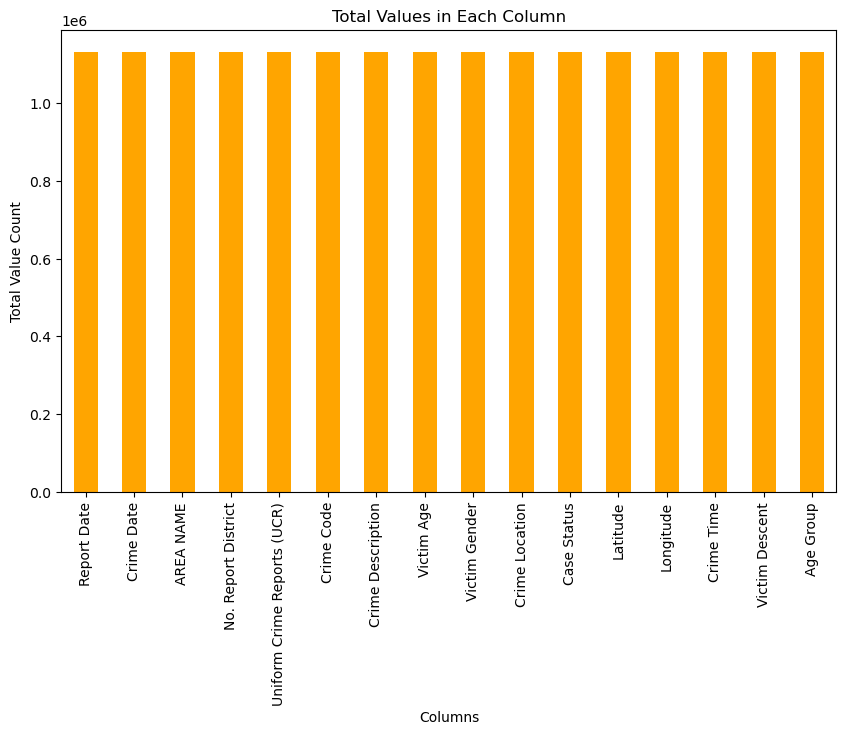

In [15]:
# Plot missing values using a bar chart
total_values = conv_df.notnull().sum()
plt.figure(figsize=(10, 6))
total_values.plot(kind='bar', color='orange')
plt.xlabel("Columns")
plt.ylabel("Total Value Count")
plt.title("Total Values in Each Column")
plt.xticks(rotation=90)
plt.show()

In [17]:
# Stop Spark session
spark.stop()